# Optimization over random waves

A boat at sea is trying to stay as high as possible on rough seas. What's the best strategy for staying high?

The one-dimensional "waves" are discrete and evolve at each time step. The boat can decide whether to move left or right (or not) at each time step. Each strategy has its own way of following "mass," that is, height in the waves. The strategy that stays on top of the most mass for the most time steps wins. To compare, we add the height at all time steps throughout a given trial.

In [1]:
# import libraries
import itertools
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

In [2]:
# global functions used by multiple strategies
def findPeakHeight(W,t,N):
    height = -t # start with worst case
    for n in np.arange(N):
        if (height < W[t+1,n]):
            height = W[t+1,n]
    return height

def newWave(N):
    wave = np.zeros(N)
    for n in np.arange(N):
        p = random.randint(-1,1)
        wave[n] = wave[n] + p
    return wave
        

def checkCurrentPeak(W,t,pos,height):
    if (W[t+1, pos] == height): 
        #print("peakheight attained, doing nothing. W: " + str(W[t+1, pos]) + " L: " + str(pos))
        #print("next L[t+1]: " + str(pos))
        return 1
    else: 
        return 0


Simple strategy: add up heights of all points to the left and right, respectively. If left side holds more "mass" than the right side, move left. If right side is larger, move right. If same, don't move.

Note: throughout this exercise, all strategies will do nothing if the current location attains the maximum global height.

In [3]:
def integrate(W,t,N,pos): 
    j = 0
    laccum = raccum = 0.0
    while (j < pos):
        laccum += W[t+1,j]
        j += 1
    j += 1

    while (j < N):
        raccum += W[t+1,j]
        j += 1 

    #print("value of laccum: "+str(laccum))
    #print("value of raccum: "+str(raccum))
    return laccum, raccum


def move1(N,pos,l,r):
    result = pos
    if (l > r and pos > 0):
        result = pos-1
        #print("move1 result: " + str(result))
    elif (l < r and pos < N-1):
        result = pos+1
        #print("move1 result: " + str(result))
    else:
        result = pos
        #print("integrals equal or at boundary... not moving")
        #print("move1 result: " + str(result))
    return result


`weightedIntegrate`: just like above except when counting up heights we divide each height by its distance from the current location. This way we follow mass that's close to the current location, rather than chasing far away waves that may not exist by the time the boat gets there. 

In [4]:
# weighted integral: look for nearby mass
def weightedIntegrate(W,t,N,pos):
    # integrate
    j = 1
    laccum = raccum = 0.0
    while (j < pos):
        laccum += W[t+1,pos-j]/j
        j += 1

    j = 1
    while (j < N-pos):
        raccum += W[t+1,pos+j]/j
        j += 1 

    # move
    result = pos
    if (laccum > raccum and pos > 0):
        result = pos-1
        #print("move1 result: " + str(result))
    elif (laccum < raccum and pos < N-1):
        result = pos+1
        #print("move1 result: " + str(result))
    else:
        result = pos
        #print("integrals equal or at boundary... not moving")
        #print("move1 result: " + str(result))
    return result

`upslope`: look to the locations one step to the left and right; move upwards if available. This strategy finds local maxima. 

In [5]:
# for now only looking at two closest points, doing nothing if same
def upslope(W,t,N,pos):
    height = W[t+1,pos]
    # take care of boundary cases first
    if (pos == 0):
        if (W[t+1,pos+1] > height):
            result = pos+1
        else:
            result = pos
    elif (pos == N-1):
        if (W[t+1,pos-1] > height):
            result = pos-1
    else: 
        j = 0
        left = W[t+1,pos-1]
        right = W[t+1,pos+1]
        # might there be a more concise way to write this than going through all 7 cases?
        if (left > height):
            if (left > right):
                result = pos-1
            elif (left == right):
                result = pos
            else:
                result = pos+1
        elif (left == height):
            if (right > height):
                result = pos+1
            else:
                result = pos
        else:
            if (right > height):
                result = pos+1
            else: 
                result = pos
    return result

`weightedIntegrate2`: just like `weightedIntegrate` except we divide by the square of the distance from current location. This favors mass thats *really* close. 

In [6]:
# second weighted integral: look for really close mass
# only difference between first and second is squaring the distance from current position in denominator
def weightedIntegrate2(W,t,N,pos):
    # integrate
    j = 1
    laccum = raccum = 0.0
    while (j < pos):
        laccum += W[t+1,pos-j]/(j*j)
        j += 1

    j = 1
    while (j < N-pos):
        raccum += W[t+1,pos+j]/(j*j)
        j += 1 

    # move
    result = pos
    if (laccum > raccum and pos > 0):
        result = pos-1
        #print("move1 result: " + str(result))
    elif (laccum < raccum and pos < N-1):
        result = pos+1
        #print("move1 result: " + str(result))
    else:
        result = pos
        #print("integrals equal or at boundary... not moving")
        #print("move1 result: " + str(result))
    return result

`chasePeak`: find location with highest point, step in that direction. 

In [7]:
# take step towards highest point
def chasePeak(W,t,N, pos, height):
    # assumes NOT currently at a peak
    #print("entering chasepeak")
    j = 1
    result = pos

    while ((pos+j) < N and (pos-j) > -1):  
        #print("top of while loop $$$$$$$$ L1 check inside chasePeak: "+ str(L1[t+1]))

        if (W[t+1,pos-j] == height): 
            if (W[t+1,pos+j] == height):
                #print("peaks equidistant: integrating..")
                laccum, raccum = integrate(W,t,N,pos)
                result = move1(N, pos, laccum, raccum)
                return result
            else:
                result = pos-1
                #print("new peak to the left.. new pos: " + str(result))
                return result
        else: 
            if (W[t+1,pos+j] == height):
                result = pos+1
                #print("new peak to the right.. new pos: " + str(result))
                return result
            #else:
                #print("peak not found, continue while loop in chasePeak.. j = " + str(j))
        j += 1

    # need to handle case where j goes out of bounds..
    if (pos+j == N):
        result = pos-1
        #print("$$$$$$$$ L1 check inside chasePeak: "+ str(L1[t+1]))
        #print("right side out of bounds; new peak to the left.. new pos: " + str(result))
        return result
    elif (pos-j == -1):
        result = pos+1
        #print("$$$$$$$$ L1 check inside chasePeak: "+ str(L1[t+1]))
        #print("left side out of bounds; new peak to the right.. new pos: " + str(result))
        return result
        
    #print("exiting chasepeak w/o moving...")
    result = pos

    return result
        


In [8]:
# discretize in time, space
T, N = 30, 15
W = np.zeros((T,N)) # wave matrix
L1 = np.zeros(T, dtype=int) # boat locations over time
L2 = np.zeros(T, dtype=int)
L3 = np.zeros(T, dtype=int)
L4 = np.zeros(T, dtype=int)



def optwave():    
    #W = np.zeros((T,N)) # wave matrix
    #L1 = np.zeros(T, dtype=int) # boat locations over time
    #L2 = np.zeros(T, dtype=int)

    peakHeight = 0
    L1[:] = np.floor(N/2) # start in the middle
    L2[:] = np.floor(N/2)
    L3[:] = np.floor(N/2)
    L4[:] = np.floor(N/2)

    for t in np.arange(T-1):
        # advance wave 
        W[t+1,:] = W[t,:] + newWave(N)
    
        # check if already at peak.. keeping this global for now
        #print("value of t: "+str(t))
        peakHeight = findPeakHeight(W,t,N)
        #print("peakheight: " + str(peakHeight))
    
        # move integrate boat
        #print("moving integrate boat...")
        if (checkCurrentPeak(W,t,L1[t],peakHeight) == 1):
            L1[t+1] = L1[t]
        else: 
            laccum, raccum = integrate(W,t,N,L1[t])
            L1[t+1] = move1(N, L1[t], laccum, raccum)

        # move chasePeak boat 
        #print("moving chasePeak boat...")
        if (checkCurrentPeak(W,t,L2[t],peakHeight) == 1):
            L2[t+1] = L2[t]
        else: 
            #print("double check new L1: "+ str(L1[t+1]))
            L2[t+1] = chasePeak(W,t,N, L2[t], peakHeight)
        #print("check new L2: "+ str(L2[t+1]))
        
        if (checkCurrentPeak(W,t,L3[t],peakHeight) == 1):
            L3[t+1] = L3[t]
        else: 
            L3[t+1] = weightedIntegrate(W,t,N,L3[t])
            
        if (checkCurrentPeak(W,t,L4[t],peakHeight) == 1):
            L4[t+1] = L4[t]
        else: 
            L4[t+1] = upslope(W,t,N,L4[t])

    #return W, L1, L2

optwave()


Let's see what happened:

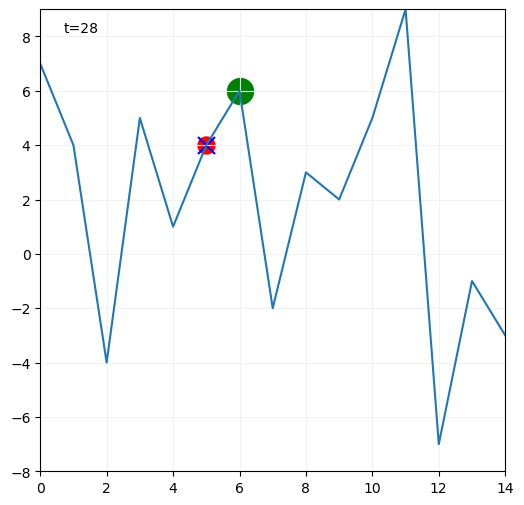

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
x = np.linspace(0,N-1,N)

# want first frame to have flat waves
#ax.cla() # clear the previous image
#ax.plot(x,W[0,:]) # plot the line
#ax.scatter(L1[0], W[0,L[0]],s=300,color='green') # boat is always 1 step behind waves
# ax.scatter(L[i], W[i+1,L[i+1]],s=300,color='green')
#plt.grid(color='0.95')
ax.set_xlim([0,N-1]) # fix the x axis
ax.set_ylim([np.min(W), np.max(W)]) # fix the y axis

# plot the rest
def animate(i):
    ax.cla() # clear the previous image
    if (i == 0):
        ax.plot(x,W[0,:]) # plot the line
        ax.scatter(L4[0], W[0,L4[0]],s=350,color='green') # boat is always 1 step behind waves
        ax.scatter(L2[0], W[0,L2[0]],s=150,color='red') # boat is always 1 step behind waves
        ax.scatter(L3[0], W[0,L3[0]],s=150,color='blue',marker="x") # boat is always 1 step behind waves

        plt.grid(color='0.95')
        ax.set_xlim([0,N-1]) # fix the x axis
        ax.set_ylim([np.min(W), np.max(W)]) # fix the y axis
        plt.annotate('t=0', xy=(0.05, 0.95), xycoords='axes fraction')
        
    else:    
        ax.plot(x,W[i,:]) # plot the line
        ax.scatter(L4[i-1], W[i,L4[i-1]],s=350,color='green') # boat is always 1 step behind waves
        ax.scatter(L2[i-1], W[i,L2[i-1]],s=150,color='red') # boat is always 1 step behind waves
        ax.scatter(L3[i-1], W[i,L3[i-1]],s=150,color='blue',marker="x") # boat is always 1 step behind waves
        
        plt.grid(color='0.95')
        ax.set_xlim([0,N-1]) # fix the x axis
        ax.set_ylim([np.min(W), np.max(W)]) # fix the y axis
        plt.annotate('t='+str(i), xy=(0.05, 0.95), xycoords='axes fraction')


anim = animation.FuncAnimation(fig, animate, frames = T-1, interval = 250, blit = False)

HTML(anim.to_jshtml())

In [18]:
# some analysis functions

# add up heights at each step
def integrateHeight(locs):
    accum = 0
    for t in np.arange(T):
        accum = accum + W[t,locs[t]]
    return accum

statistical review: do lots of trials and see who wins "on average"

In [38]:
L1count = L2count = L3count = L4count = 0
L1avg = L2avg = L3avg = L4avg = 0.0
M = 300

for n in np.arange(M):
    optwave()
    L4count += integrateHeight(L4)
    L2count += integrateHeight(L2)
    L3count += integrateHeight(L3)

    L4avg = L4count/M
    L2avg = L2count/M
    L3avg = L3count/M

print(L4avg)
print(L2avg)
print(L3avg)


87.00666666666666
97.66666666666667
97.46
